In [16]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

import nltk
from nltk.corpus import stopwords
STOPWORDS = stopwords.words('english')

import matplotlib.pyplot as plt

In [17]:
vocab_size = 50000
embedding_dim = 64
max_length = 15
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

In [18]:
news_json = pd.read_json("News_Category_Dataset_v2.json", lines=True)
news_json['category'] = news_json['category'].str.split(' ').str[0]
news_json = news_json.query('category == "POLITICS" or category == "WELLNESS" or category == "ENTERTAINMENT" or category == "TRAVEL" or category == "STYLE" or category == "PARENTING"')
news_json = news_json.sample(frac=1, random_state=100).reset_index(drop=True)
news_json['headline'] = news_json['headline'].apply(lambda x: ' '.join([word for word in x.split() if word not in (STOPWORDS)]))
news_json

,category,headline,authors,link,short_description,date
0,PARENTING,My Child's Dream: To Have Friends,"Louise Kinross, Contributor\nEditor, BLOOM",https://www.huffingtonpost.com/entry/genetic-d...,We expected that our son's genetic disorder wo...,2012-02-13
1,POLITICS,Trump Lawyer Shares Image Of Hillary Saying Sh...,Arthur Delaney,https://www.huffingtonpost.com/entry/trump-law...,Not very presidential.,2016-06-28
2,TRAVEL,Hong Kong's Food Surprises (VIDEO),"La Carmina, Contributor\nTravel TV host, fashi...",https://www.huffingtonpost.com/entry/hong-kong...,If you go to Hong Kong and eat nothing but Chi...,2012-12-16
3,ENTERTAINMENT,Golden Globes 2014 Winners Unveiled At 71st An...,,https://www.huffingtonpost.com/entry/golden-gl...,"Going into the night, ""12 Years A Slave"" and ""...",2014-01-12
4,ENTERTAINMENT,Ryan Gosling Was Never The Movie Star We Made ...,Lauren Duca,https://www.huffingtonpost.com/entry/middlebro...,,2015-04-23
...,...,...,...,...,...,...
97086,WELLNESS,Addicted To Coffee? How To Break The Habit For...,,https://www.huffingtonpost.com/entry/kick-your...,"Quitting caffeine isn't easy, but if you feel ...",2013-08-14
97087,WELLNESS,"Mark Cahill, 51-Year-Old British Man With Para...",,https://www.huffingtonpost.com/entry/mark-cahi...,Cahill's operation marks the UK's first hand t...,2013-01-04
97088,WELLNESS,For Pain Your Mouth... Chew This!,"Marjory Abrams, Contributor\nChief Content Off...",https://www.huffingtonpost.com/entry/cloves-mo...,The power of natural medicine never ceases to ...,2012-11-28
97089,TRAVEL,Awesome Artful Vintage Olympic Posters,"Conde Nast Traveler, Contributor\nConde Nast T...",https://www.huffingtonpost.com/entry/awesome-a...,There are a lot of advertisements out there fo...,2014-01-29


In [19]:
dataset = news_json[['category', 'headline']]
dataset[0:20]

,category,headline
0,PARENTING,My Child's Dream: To Have Friends
1,POLITICS,Trump Lawyer Shares Image Of Hillary Saying Sh...
2,TRAVEL,Hong Kong's Food Surprises (VIDEO)
3,ENTERTAINMENT,Golden Globes 2014 Winners Unveiled At 71st An...
4,ENTERTAINMENT,Ryan Gosling Was Never The Movie Star We Made ...
5,WELLNESS,Leadership You
6,PARENTING,When My Son Became A Biter
7,TRAVEL,"The Best Time To Book A Plane Ticket, Accordin..."
8,ENTERTAINMENT,Beyoncé Addresses Elevator Incident In 'Flawle...
9,POLITICS,"CHARLIE COOK: Hillary 'Rusty,' 'Has Lost Her F..."


In [20]:
train_size = int(len(dataset) * 0.8)
train_data = dataset[0:train_size]
test_data = dataset[train_size:]
train_data, test_data

(            category                                           headline
 0          PARENTING                  My Child's Dream: To Have Friends
 1           POLITICS  Trump Lawyer Shares Image Of Hillary Saying Sh...
 2             TRAVEL                 Hong Kong's Food Surprises (VIDEO)
 3      ENTERTAINMENT  Golden Globes 2014 Winners Unveiled At 71st An...
 4      ENTERTAINMENT  Ryan Gosling Was Never The Movie Star We Made ...
 ...              ...                                                ...
 77667       POLITICS                      Behemoth Bathrobe: A Dialogue
 77668       WELLNESS  Day Five: Super Bowl XLVI Guilt-Free Cauliflow...
 77669      PARENTING  Tracy Moutafis, Mom, Dances To 'Celebration' A...
 77670       POLITICS  Anthony Weiner Gets Prison Time For Sexting A ...
 77671       WELLNESS                          Deep Listening: Ear Heart
 
 [77672 rows x 2 columns],
             category                                           headline
 77672      PARENTING 

In [21]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_data['headline'])
word_index = tokenizer.word_index
dict(list(word_index.items())[0:10])

{'<OOV>': 1,
 'the': 2,
 'to': 3,
 'a': 4,
 'in': 5,
 'of': 6,
 'for': 7,
 'is': 8,
 'and': 9,
 'trump': 10}

In [22]:
train_sequences = tokenizer.texts_to_sequences(train_data['headline'])
train_sequences[0:10]

[[43, 1739, 847, 3, 46, 781],
 [10, 922, 465, 2090, 6, 64, 1122, 207, 24075, 55, 24076],
 [5095, 17808, 190, 2051, 29],
 [546, 785, 244, 1764, 7609, 19, 24077, 3049, 284, 2526],
 [242, 4202, 81, 208, 2, 238, 197, 49, 289, 264, 40, 3, 25],
 [2326, 14],
 [86, 43, 339, 1446, 4, 24078],
 [2, 38, 74, 3, 512, 4, 1251, 2858, 719, 3, 16, 79],
 [913, 2859, 7610, 3482, 5, 14548, 5325, 12396, 1716, 2052],
 [2053, 3219, 64, 24079, 109, 7129, 203, 32, 24080]]

In [23]:
train_pad = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
train_pad[100:110]

array([[ 1175,  1516,   404,   771,    17,    84,     9,   913,  1790,
           41,    13,   765,   117,   755,     0],
       [   22,    10,  1128,     3,  3946, 24107,    53,  7144,    84,
         1742,    32,   565,     0,     0,     0],
       [14562, 17824,    34,    64,   640,  5100,  1074,  8213,   264,
           30,     3,   336,  8927,  5644,     3],
       [  131,     9,  2471,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [ 1200,  2862,   553,   199,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [    2,  1691,     6, 14563,    12,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [   10,  2194,   747,   161,    11,   686,    39,    89,  5939,
         6291,     6,  2092,     0,     0,     0],
       [   50,  2700,  1367,     6,   236,  4361,    44,  1047,     3,
          328,  1130,     0,     0,     0,     0],
       [24108,  9808, 24

In [24]:
test_sequences = tokenizer.texts_to_sequences(test_data['headline'])
test_pad = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_pad[1:10]

array([[ 4589, 10458,  2113,  7757,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [   16,   165,    76,    80, 14584, 14585,   242,  5501,     9,
           31,   712,  1910,   501,    12,     0],
       [   42,  4565,   390,     2,  4565,   553,  2938, 28757,     1,
         9297,  3565,  4124,  1048,   556,     1],
       [18662, 18663,  6631,    22,    44, 19533,  6564,   748,    27,
          350,   156,   493,     0,     0,     0],
       [  600,  1537,    35,   671,   760,    13,    10,   871,  2536,
           50,    87,  2498,     0,     0,     0],
       [ 9788,   650,   294,     6,    77,   837,  8012,    77,   183,
          221,     0,     0,     0,     0,     0],
       [   28,    42,  5400,   402,   221,   482,  1689,   392,     0,
            0,     0,     0,     0,     0,     0],
       [   54,    34,  4776,    35,    25,   439,   265,  2718,  8161,
            7, 14804,     0,     0,     0,     0],
       [ 1127, 10381,  1

In [25]:
category_tokenizer = Tokenizer()
category_tokenizer.fit_on_texts(dataset['category'])

train_category_sequence = np.array(category_tokenizer.texts_to_sequences(train_data['category']))
test_category_sequence = np.array(category_tokenizer.texts_to_sequences(test_data['category']))
train_category_sequence[0:11]

array([[6],
       [1],
       [5],
       [3],
       [3],
       [2],
       [6],
       [5],
       [3],
       [1],
       [6]])

In [26]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=15))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(embedding_dim))
model.add(Dense(embedding_dim, activation='relu'))
model.add(Dense(7, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 15, 64)            3200000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 15, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 455       
Total params: 3,237,639
Trainable params: 3,237,639
Non-trainable params: 0
_________________________________________________________________


In [27]:
epochs = 10
history = model.fit(train_pad, train_category_sequence, epochs=epochs, validation_data=(test_pad, test_category_sequence), verbose=2)


Train on 77672 samples, validate on 19419 samples
Epoch 1/10
77672/77672 - 49s - loss: 0.7654 - accuracy: 0.7274 - val_loss: 0.4890 - val_accuracy: 0.8376
Epoch 2/10
77672/77672 - 47s - loss: 0.3691 - accuracy: 0.8824 - val_loss: 0.4465 - val_accuracy: 0.8546
Epoch 3/10
77672/77672 - 49s - loss: 0.2501 - accuracy: 0.9203 - val_loss: 0.4571 - val_accuracy: 0.8529
Epoch 4/10
77672/77672 - 48s - loss: 0.1871 - accuracy: 0.9414 - val_loss: 0.5015 - val_accuracy: 0.8488
Epoch 5/10
77672/77672 - 49s - loss: 0.1518 - accuracy: 0.9522 - val_loss: 0.5588 - val_accuracy: 0.8487
Epoch 6/10
77672/77672 - 49s - loss: 0.1231 - accuracy: 0.9606 - val_loss: 0.6090 - val_accuracy: 0.8414
Epoch 7/10
77672/77672 - 49s - loss: 0.1044 - accuracy: 0.9658 - val_loss: 0.6378 - val_accuracy: 0.8426
Epoch 8/10
77672/77672 - 48s - loss: 0.0885 - accuracy: 0.9710 - val_loss: 0.7096 - val_accuracy: 0.8414
Epoch 9/10
77672/77672 - 49s - loss: 0.0763 - accuracy: 0.9740 - val_loss: 0.7808 - val_accuracy: 0.8395
Epoch

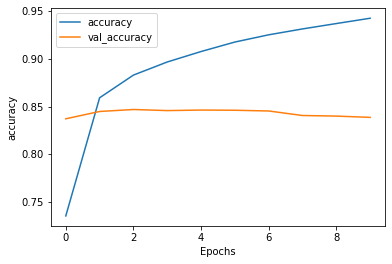

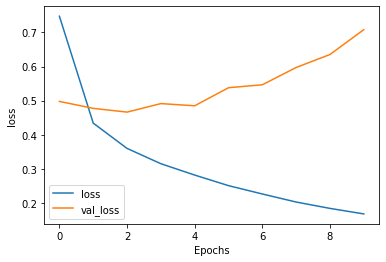

In [13]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [28]:
new_headline = ['Biden to host two crucial Democratic senators Monday to talk infrastructure at start of critical week']
seq = tokenizer.texts_to_sequences(new_headline)
padded = pad_sequences(seq, maxlen=15)
pred = model.predict(padded)
labels = ["NONE", "POLITICS", "WELLNESS", "ENTERTAINMENT", "STYLE", "TRAVEL", "PARENTING"]
print(pred, labels[np.argmax(pred)])

[[1.8200012e-18 9.9986637e-01 6.6346598e-05 4.4178163e-05 1.6246580e-05
  3.6224274e-06 3.1784684e-06]] POLITICS


In [29]:
another_headline = ['Bird strike forces Delta Air Lines flight from Atlanta to turn around']
seq = tokenizer.texts_to_sequences(another_headline)
padded = pad_sequences(seq, maxlen=15)
pred = model.predict(padded)
labels = ["NONE", "POLITICS", "WELLNESS", "ENTERTAINMENT", "STYLE", "TRAVEL", "PARENTING"]
print(pred, labels[np.argmax(pred)])

[[3.0213947e-23 5.4781340e-06 7.2920829e-04 2.6875494e-05 8.0916384e-04
  9.9489200e-01 3.5372078e-03]] TRAVEL
